- 시맨틱 세그멘테이션을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보자.
- 최종적으로 만들어 볼 모델은 아래와 같다.
- 입력 이미지 위에 도로 영역으로 인식한 영역을 흰색으로 오버레이 한 이미지이다.
![image](https://d3s0tskafalll9.cloudfront.net/media/original_images/result.gif)
---
## 학습 내용
2. 시맨틱 세그멘테이션 데이터셋
    - Semantic Segmentation 학습을 위한 KITTI Dataset을 준비한다.

3. 시맨틱 세그멘테이션 모델
    - U-Net model을 작성한다.

4. 시맨틱 세그멘테이션 모델 시각화
    - 학습된 결과를 시각화한다.

## 14-2. 시맨틱 세그멘테이션 데이터셋

### 이미지, 데이터 가져오기
- 먼저 시맨틱 세그멘테이션으로 도로의 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱 해야 한다.
<br/>

[데이터 출처](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)

- 세그멘테이션 데이터는 이미지 형태의 라벨로 되어있다.

![image](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10.max-800x600.png)
- KITTI 데이터셋

![image](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10_label.max-800x600.png)
- KITTI 데이터셋 segmentation

![image](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10_mqPgQu0.max-800x600.png)
- KITTI 데이터셋 segmentation_rgb
---

### 데이터 로더(data loader) 만들기
- 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들어보자.
- 로더는 입력값 (224, 224),
- 출력값 (224, 224)
- 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱 해야 한다.
<br/><br/>
- 이때 데이터 로더에 augmentation을 적용해보자.
- 파이썬에서 많이 쓰이는 augmentation 라이브러리 중 albumentations을 사용해보자.
```
$ pip list | grep albumentations
```
- 또한 학습셋의 일정량을 검증 데이터셋(validation dataset)으로 활용할 수 있도록 해야 한다.

In [ ]:
#필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


- AIbumentation에서 다양한 augmenation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예이다. imgaug의 Sometimes()의 유사한 기능이다.

In [ ]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

- HorizontalFlip(p=0.5) : 50%의 확률로 이미지를 좌우로 뒤집는다.
- RandomSizedCrop(...) : 50%의 확률로 랜덤 크롭을 수행한다. 주어진 높이 범위 내에서 랜덤하게 크롭하고, 가로/세로 비율을 고려하여 크롭한다.
    - 크롭 : 이미지에서 일부 영역을 잘라내는 작업
- Resize(...) : 입력 이미지를 224x224 크기로 리사이즈한다. 이는 모델에 입력되는 이미지 크기를 통일시키기 위해서이다.
- 훈련 데이터에 다양한 변형을 적용하여 모델의 일반화 성능을 향상시키기 위해서 사용하고,
- 테스트 데이터에는 이미지 크기를 통일시켜주는 Resize만 수행한다.

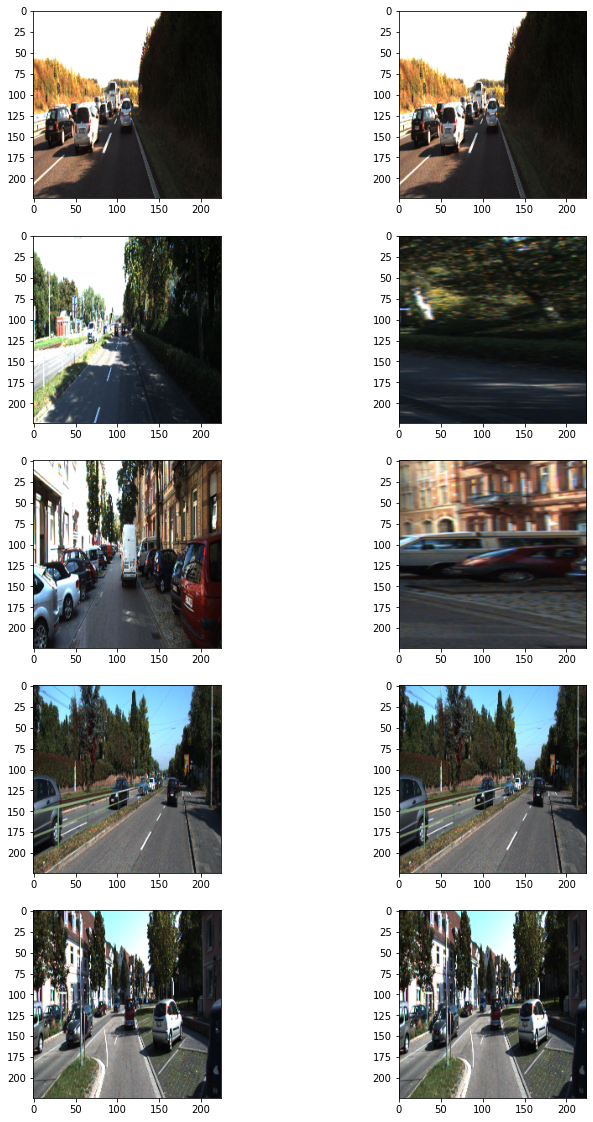

In [ ]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

- 이제 데이터셋을 구성해보자.
- 이번에는 tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해보자.

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self,
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]

  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])

    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

- Sequence 클래스를 상속받아 KITTI 데이터셋을 처리하는 데이터 generator를 정의한 것이다.

> Data Generator
> - 주로 대량의 데이터를 효율적으로 처리하고 모델에 공급하기 위한 반복 가능한(iterable) 객체를 구현하는 클래스 또는 함수를 말한다.
- 위 KittiGenerator 클래스에서는 KITTI 데이터셋에 대한 입력 이미지와 라벨을 로드하고, 훈련 및 테스트 용으로 데이터를 나누어 제공하며, 필요에 따라 데이터 증강을 적용할 수 있다.
<br/><br/>
- '__init__(self, dir_path, batch_size=16, img_size=(224, 224, 3), output_size=(224, 224), is_train=True, augmentation=None)' :
    - 생성자 메서드로, 데이터 제너레이터의 초기화를 담당
    - 디렉토리 경로, 배치 크기, 입력 및 출력 이미지 크기, 훈련 또는 테스트 여부, 적용할 augmentation 함수 등을 설정

- 'load_dataset(self)' :
    - KITTI 데이터셋을 로드하는 메서드
    - 디렉토리에서 이미지와 라벨의 경로를 확인하고, 훈련 또는 테스트에 따라 데이터를 나눠 로드한다.

- '__len__(self)' :
    - 전체 데이터셋의 크기를 배치 크기로 나눈 값을 반환한다.
    - 이 값은 한 에폭(epoch) 동안의 반복 횟수를 결정

- '__getitem__(self, index)' :
    - 주어진 인덱스에 해당하는 배치를 반환한다.
    - 입력 이미지와 라벨을 로드하고, augmentation을 적용한 후 반환

- 'on_epoch_end(self)' :
    - 한 에폭이 끝날 때 호출되는 메서드
    - 훈련 중에는 데이터를 무작위로 섞어 에폭마다 다양한 순서로 데이터를 사용할 수 있도록 한다.

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

## 14-3. 시맨틱 세그멘테이션 모델
![image](https://d3s0tskafalll9.cloudfront.net/media/images/u-net_1kfpgqE.max-800x600.png)

### 모델 구조 만들기
- 시그멘테이션 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현해보자.
- 사용에 필요한 레이어와 연산은 다음과 같다. 그리고 필요에 따라서 Dropout 등의 다른 레이어를 적용해보자.

```
- Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
```

In [ ]:
def build_model(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    maxpool1 = MaxPooling2D(2)(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(maxpool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    maxpool2 = MaxPooling2D(2)(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(maxpool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    maxpool3 = MaxPooling2D(2)(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(maxpool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv4)
    maxpool4 = MaxPooling2D(2)(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(maxpool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(conv5)

    up6 = Conv2DTranspose(512, 2, strides = (2, 2), padding = 'same')(conv5)
    up6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides = (2, 2), padding = 'same')(conv6)
    up7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides = (2, 2), padding = 'same')(conv7)
    up8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides = (2, 2), padding = 'same')(conv8)
    up9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)

    outputs = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = outputs)

    return model

In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 9s 693ms/step - loss: 0.6893 - val_loss: 0.6822
Epoch 2/100
11/11 [==============================] - 7s 655ms/step - loss: 0.6674 - val_loss: 0.6255
Epoch 3/100
11/11 [==============================] - 7s 664ms/step - loss: 0.4294 - val_loss: 0.2804
Epoch 4/100
11/11 [==============================] - 7s 650ms/step - loss: 0.2153 - val_loss: 0.2819
Epoch 5/100
11/11 [==============================] - 7s 627ms/step - loss: 0.2356 - val_loss: 0.2819
Epoch 6/100
11/11 [==============================] - 7s 619ms/step - loss: 0.1728 - val_loss: 0.2819
Epoch 7/100
11/11 [==============================] - 7s 614ms/step - loss: 0.2197 - val_loss: 0.2819
Epoch 8/100
11/11 [==============================] - 7s 613ms/step - loss: 0.2045 - val_loss: 0.2819
Epoch 9/100
11/11 [==============================] - 7s 609ms/step - loss: 0.2696 - val_loss: 0.2819
Epoch 10/100
11/11 [==============================] - 7s 609ms/step - loss: 0.2529 - val_lo

## 14-4. 시맨틱 세그멘테이션 모델 시각화

In [ ]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

- 테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference) 한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어보자.
- 이때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray) 해보자.
- PIL 패키지를 사용한다면 Image.blend를 활용할 수 있다.

In [ ]:
def get_output(model, preproc, image_path, output_path):
    # 이미지 파일을 읽어옴
    origin_img = imread(image_path)

    # 이미지 전처리 수행
    data = {"image": origin_img}
    processed = preproc(**data)

    # 모델에 전처리된 이미지 입력하고 예측 결과 얻음
    output = model(np.expand_dims(processed["image"] / 255, axis=0))

    # 이진 분류 문제에서는 주로 0.5를 threshold로 설정하여 이상/정상을 결정
    output = (output[0].numpy() > 0.5).astype(np.uint8).squeeze(-1) * 255

    # 예측 결과를 이미지로 변환
    output = Image.fromarray(output)

    # 원본 이미지를 RGBA 모드로 변환하여 배경 투명도 추가
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')

    # 예측 결과를 원본 이미지와 합성하여 시각화
    output = Image.blend(background, output, alpha=0.5)

    # 시각화된 결과를 화면에 표시
    output.show()

    # 결과 이미지 반환
    return output

- 위의 함수는 입력된 이미지 파일에 대해 모델을 사용하여 도로인식 예측을 수행하고, 예측 결과를 원본 이미지와 함께 토명도를 조절하여 시각화한다.
1. 이미지 읽기 : 'imread' 함수를 사용하여 입력 이미지 파일을 읽어온다.
2. 이미지 전처리 : 미리 정의된 전처리 함수 'preproc'를 사용하여 이미지를 전처리한다.
3. 모델 예측 : 전처리된 이미지를 모델에 입력하고 예측 결과를 얻는다.
4. 이진 분류 및 이진화 : 모델의 예측 결과를 이진화하여 도로 여부를 결정한다.
5. 이미지로 변환 : 이진화된 예측 결과를 이미지로 변환한다.
6. 투명도 추가 및 합성 : 원본 이미지와 예측 결과를 RGBA 모드로 변환하고, 원본 이미지와 예측 결과를 투명도를 조절하여 합성한다.
7. 결과 시각화 : 시각화된 결과를 화면에 표시
8. 결과 반환 : 최종 결과 이미지를 반환
<br/><br/>
- 위에서 작성한 함수를 이용해 시각화 해보자

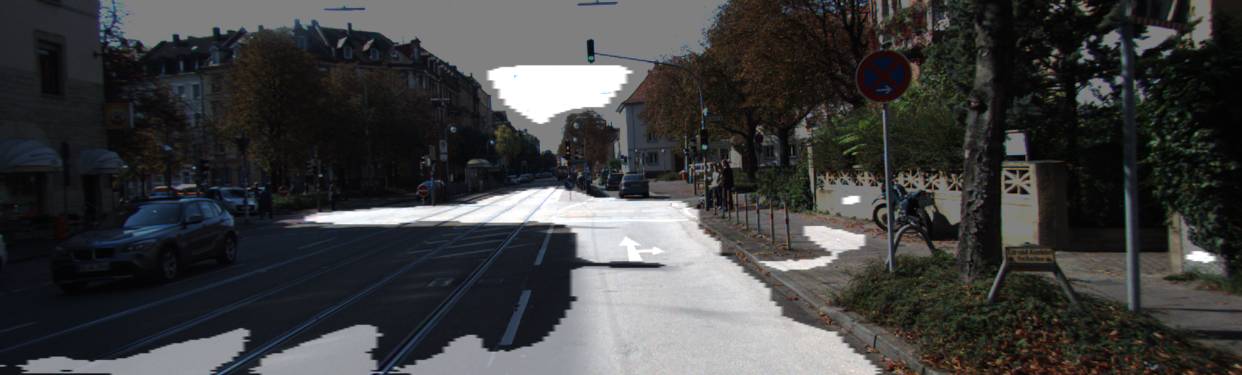

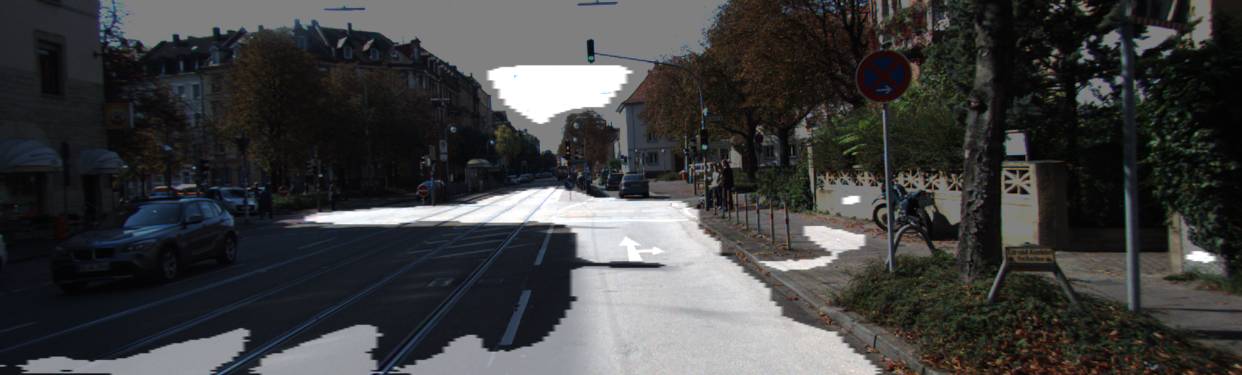

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
get_output(
     model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

- 세그멘테이션 성능을 정량적으로 측정하기 위한 방법으로 IoU를 계산한다.
- IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1
- 나머지 부분이 0으로 표시된 행렬,
- 그리고 라벨 데이터에서 도로 영역이 1,
- 나머지 부분이 0으로 표시된 행렬이 필요하다.
- 각각을 prediction, traget이라고 불렀을 때 이를 계산하는 함수를 구현해보자.

In [ ]:
def calculate_iou_score(target, prediction):
    # Intersection을 구하는 코드
    intersection = np.logical_and(target, prediction)

    # Union을 구하는 코드
    union = np.logical_or(target, prediction)

    # IoU 스코어를 계산
    iou_score = np.sum(intersection) / np.sum(union)

    # 결과값을 float로 변환
    iou_score = float(iou_score)

    # IoU 스코어 출력
    print('IoU : %f' % iou_score)

    return iou_score

- np.logical_and(target, prediction)은 두 이진화된 이미지에서 동일한 위치의 픽셀이 모두 1인 경우에만 1로 설정된 새로운 배열
- np.logical_or(target, prediction)은 두 이진화된 이미지에서 해당 픽셀이 하나 이상이라도 활성화된 경우 1로 설정된 새로운 배열
- Intersection을 Union으로 나눠 IoU 스코어 계산한다.
- IoU는 0에서 1사이의 값으로, 1에 가까울수록 예측이 정확하다고 판단

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역

    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!

    if label_path:
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

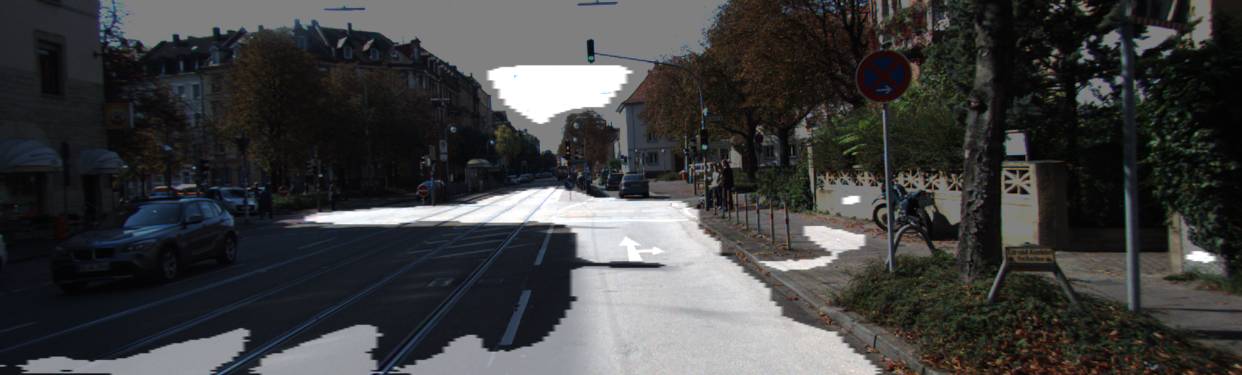

IoU : 0.419641


0.41964089410040306

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)